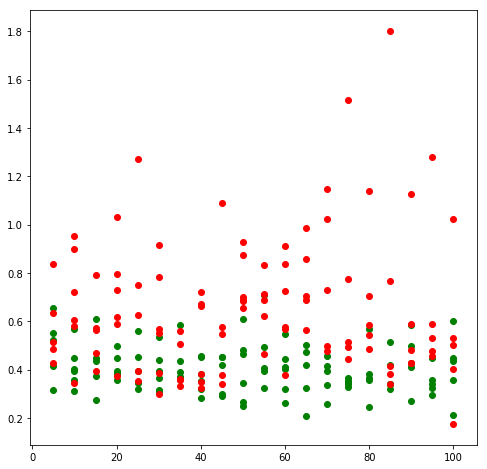

In [5]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import metrics

%matplotlib inline
# read traingin data with following csv structure
# distance, sdX, meanX, sdY, meanY, abnormal
df_data = pd.read_csv("/Users/dhanushka/Desktop/mydata/fypit/anaconda/data/CalculatedData2.csv")
# read testing data
df_data_test = pd.read_csv("/Users/dhanushka/Desktop/mydata/fypit/anaconda/data/CalculateDataTest2.csv")

# plot standard deviation vs distance
fig_normal = plt.figure(figsize=(8,8,))
df_steady  = df_data.loc[df_data['abnormal'] == 0]
df_unsteady  = df_data.loc[df_data['abnormal'] == 1]
# plot steady pattern standard deviation
plt.scatter(df_steady['distance'], df_steady['sdX'],color='green')
# plot unsteady pattern standard deviation
plt.scatter(df_unsteady['distance'], df_unsteady['sdX'],color='red')
plt.show()

In [6]:
# apply SVM on distance vs standard deviation dataset
clf = svm.SVC(kernel='linear',gamma='auto')
X = df_data[['distance','sdX']]
y = df_data['abnormal']
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

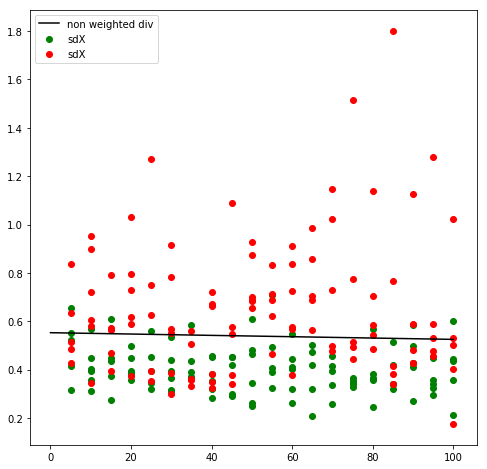

In [9]:
w = clf.coef_[0]
# plot SVM result with the dataset
a = -w[0] / w[1]

fig_normal = plt.figure(figsize=(8,8,))
xx = np.linspace(0,100)
yy = a * xx - clf.intercept_[0] / w[1]
h0 = plt.plot(xx, yy, 'k-', label="non weighted div")

plt.scatter(df_steady['distance'], df_steady['sdX'],color='green')
plt.scatter(df_unsteady['distance'], df_unsteady['sdX'],color='red')
plt.legend()
plt.show()

In [10]:
# cross over two input chromosome s
def crossOver(value1, value2):
    returnValue1 = []
    returnValue2 = []
    # generate random index as crossover point
    randVal = random.randint(0, len(value1)-1)
    loc=0
    for retVal in value1:
        # crossover 0->randVal section in two cromosome
        if loc<randVal:
            returnValue1.append(value1[loc])
            returnValue2.append(value2[loc])
        # crossover randVal->len(value1) section in two cromosome
        else:
            returnValue1.append(value2[loc])
            returnValue2.append(value1[loc])
        loc=loc+1
    return returnValue1, returnValue2

# list of possible variables that can have in expression
variable = ["df_data['sdX']", "df_data['sdY']", "df_data['meanX']", "df_data['meanY']"]
# list of possible operations that can have in expression
operation = ["+", "-", "*", "/"]

# generate random mutations for given cromosome
def mutate(value):
    # select random index to mutate
    randVal = random.randint(0, len(value)-1)
    if randVal%2 == 0:
        # if selected is variable select random variable
        randOpValue = random.randint(0,len(variable)-1)
        # replace cromosome variable with random variable
        value[randVal] = variable[randOpValue]
        return value
    else:
        # if selected is operation select random operation
        randOpValue = random.randint(0,len(operation)-1)
        # replace cromosome operation with random operation
        value[randVal] = operation[randOpValue]
        return value

# convert expression array to string
def convertToString(value):
    return ' '.join(value)

# calcuate fitness function by using accuraccy of SVM classification method
def calculateFitness(expression):
    # evaluate expression in python
    eval_value = eval(expression)
    # rename new dataframe as "param"
    df_value = pd.DataFrame(eval_value.rename("param"), columns=['param'])
    # join new dataframe main dataframe
    df_joined = df_data.join(df_value)
    
    # fit with SVM
    clf = svm.SVC(kernel='linear',gamma='auto')
    X = df_joined[['distance','param']]
    y = df_joined['abnormal']
    clf.fit(X, y)
    
    # print graph
    printGraph(df_joined,clf)
    
    # generate expression for testing dataset
    expression_test = expression.replace("df_data", "df_data_test")
    # evaluate expression in python
    eval_test_value = eval(expression_test)
    # rename new dataframe as "param"
    df_value_test =  pd.DataFrame(eval_test_value.rename("param"), columns=['param'])
    # join new dataframe main test dataframe
    df_joined_test = df_data_test.join(df_value_test)
    X_test = df_joined_test[['distance','param']]
    y_test = df_joined_test['abnormal']
    #print(clf.predict(X_test))
    #print("Accuracy:",metrics.accuracy_score(y_test, clf.predict(X_test)))
    # mesure accuracy of the SVM by comparing with the predicted result
    return metrics.accuracy_score(y_test, clf.predict(X_test))
    
# visualise graph
def printGraph(df_joined,clf):
    w = clf.coef_[0]
    # visualise steady dataset
    df_normal_temp  = df_joined.loc[df_joined['abnormal'] == 0]
    # visualise unsteady dataset
    df_abnormal_temp  = df_joined.loc[df_joined['abnormal'] == 1]
    # show steady dataset with green color
    plt.scatter(df_normal_temp['distance'], df_normal_temp['param'],color='green')
    # show unsteady dataset with red color
    plt.scatter(df_abnormal_temp['distance'], df_abnormal_temp['param'],color='red')
    # show SVM line that seperate two clusters
    a = -w[0] / w[1]
    xx = np.linspace(0,100)
    yy = a * xx - clf.intercept_[0] / w[1]
    h0 = plt.plot(xx, yy, 'k-', label="non weighted div")
    plt.legend()
    plt.show()

# run genetic alogrithm in recursive
def applyGeneticAlgo(start,depth):
    # expression with maximum fitness
    max1 = []
    # maximum fitness value
    max1Fitness=0
    # expression with second hieghst maximum fitness
    max2 = []
    # second heights maximum fitness value
    max2Fitness=0
    
    # loop over all input expression
    for initInput in start:
        # calcuate fitness for expression
        fitness=calculateFitness(convertToString(initInput))
        # save maximum fitness expression
        if max1Fitness < fitness:
            max2Fitness=max1Fitness
            max2=max1
            max1Fitness=fitness
            max1=initInput
        # save second maximum fitness expression
        elif max2Fitness < fitness:
            max2Fitness = fitness
            max2 = initInput
    print('maxFit value: ', max1)
    print('maxFit input: ', max1Fitness)
    print('depth: ', depth)
    # if depth is zero, stop recursion calling
    if depth==0:
        return
    
    # crossover two best expression
    crossOver1,crossOver2=crossOver(max1, max2)
    
    # generate 10 expression with mutation crossover1 expression
    resultSet=[]
    resultSet.append(tuple(mutate(crossOver1)))
    resultSet.append(tuple(mutate(crossOver1)))
    resultSet.append(tuple(mutate(crossOver1)))
    resultSet.append(tuple(mutate(crossOver1)))
    resultSet.append(tuple(mutate(crossOver1)))
    resultSet.append(tuple(mutate(crossOver1)))
    resultSet.append(tuple(mutate(crossOver1)))
    resultSet.append(tuple(mutate(crossOver1)))
    resultSet.append(tuple(mutate(crossOver1)))
    resultSet.append(tuple(mutate(crossOver1)))
    # call recursively
    applyGeneticAlgo(resultSet, depth-1)
    
    # generate 10 expression with mutation of crossover2 expression
    resultSet=[]
    resultSet.append(tuple(mutate(crossOver2)))
    resultSet.append(tuple(mutate(crossOver2)))
    resultSet.append(tuple(mutate(crossOver2)))
    resultSet.append(tuple(mutate(crossOver2)))
    resultSet.append(tuple(mutate(crossOver2)))
    resultSet.append(tuple(mutate(crossOver2)))
    resultSet.append(tuple(mutate(crossOver2)))
    resultSet.append(tuple(mutate(crossOver2)))
    resultSet.append(tuple(mutate(crossOver2)))
    resultSet.append(tuple(mutate(crossOver2)))
    # call recursively
    applyGeneticAlgo(resultSet, depth-1)
    

In [ ]:
from nltk import CFG
from nltk.parse.generate import generate
import random

population = []
# set of CFG rules to generate expression
demo_grammar = """
  S -> EXP OP EXP OP EXP OP EXP|EXP OP EXP OP EXP OP EXP OP EXP
  EXP -> "df_data['sdX']"|"df_data['sdY']"|"df_data['meanX']"|"df_data['meanY']"
  OP -> '+'|'*'|'-'|'/'
"""
grammar = CFG.fromstring(demo_grammar)

# generate random expression for given set of CFG rules
for sentence in generate(grammar, n=1):
    print(sentence)
#    calculateFitness(convertToString(sentence))
#calculateFitness("df_data['sdX'] + df_data['meanX'] + df_data['sdY'] + df_data['meanY']")  
#print(mutate(["df_data['sdX']", "+", "df_data['meanX']", "+", "df_data['sdY']", "+", "df_data['meanY']"]))
#print(crossOver(["df_data['sdX1']", "+1", "df_data['meanX1']", "+1", "df_data['sdY1']", "+1", "df_data['meanY1']"],["df_data['sdX2']", "+2", "df_data['meanX2']", "+2", "df_data['sdY2']", "+2", "df_data['meanY2']"])[0])
# apply genetic algorythm to find bestfit expression
applyGeneticAlgo([
    ["df_data['sdX']", "*", "df_data['meanX']", "*", "df_data['sdY']", "*", "df_data['meanY']", "*","df_data['sdX']", "*", "df_data['meanX']"],
    ["df_data['sdX']", "+", "df_data['meanX']", "+", "df_data['sdY']", "+", "df_data['meanY']", "+", "df_data['sdX']", "+", "df_data['meanX']"],
    ["df_data['sdX']", "-", "df_data['meanX']", "-", "df_data['sdY']", "-", "df_data['meanY']", "-", "df_data['meanX']", "-", "df_data['sdY']"]
],2)

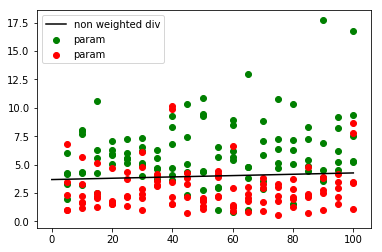

0.7860696517412935

In [11]:
# visualisation of bestfit expression
calculateFitness("1 / df_data['sdX'] / df_data['sdY']")

In [12]:
clf = svm.SVC(kernel='linear',gamma='auto')
df_value = 1/df_data['sdX']/df_data['sdY']
eval_value = pd.DataFrame(df_value.rename("param"), columns=['param'])
df_joined=df_data.merge(eval_value, left_index=True, right_index=True)
#print(eval_value)
X = df_joined[['distance','param']]
y = df_joined['abnormal']
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

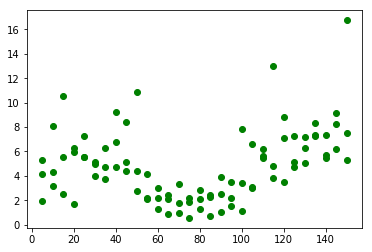

In [13]:
df_road = pd.read_csv("/Users/dhanushka/Desktop/mydata/fypit/anaconda/data/segmantingroad.csv")
segments_data = 1/df_road['sdX']/df_road['sdY']
plt.scatter(df_road['distance'], segments_data,color='green')

In [14]:
mod_data2= pd.DataFrame(segments_data.rename("param"), columns=['param'])
segmented_data=df_road.merge(mod_data2, left_index=True, right_index=True)
for x in range(30):
    location = (x+1)*5
    prediction = 0
    prediction += clf.predict([[segmented_data.loc[segmented_data['distance'] == location].iloc[0]['distance'], segmented_data.loc[segmented_data['distance'] == location].iloc[0]['param']]])
    prediction += clf.predict([[segmented_data.loc[segmented_data['distance'] == location].iloc[1]['distance'], segmented_data.loc[segmented_data['distance'] == location].iloc[0]['param']]])
    prediction += clf.predict([[segmented_data.loc[segmented_data['distance'] == location].iloc[2]['distance'], segmented_data.loc[segmented_data['distance'] == location].iloc[0]['param']]])
    status = ""
    if prediction>2:
        status="unsteady"
    else:
        status="steady"
    print(status)

steady
steady
steady
steady
steady
steady
steady
steady
steady
steady
unsteady
unsteady
unsteady
unsteady
unsteady
unsteady
unsteady
unsteady
unsteady
unsteady
unsteady
steady
steady
steady
steady
steady
steady
steady
steady
steady
